<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Simple $1$-D elliptic solver in Python 

## Authors: Thiago Assumpção & Zach Etienne


## In this tutorial, we implement an 1D elliptic solver using the hyperbolic relaxation approach in Python. 

**Notebook Status:** <font color='red'><b> Not validated </b></font>

**Validation Notes:** This tutorial notebook has been confirmed to be self-consistent with its corresponding NRPy+ module, as documented [below](#code_validation).

### NRPy+ Source Code for this module: [_____.py](../edit/_____.py)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#intro): Introduction
1. [Step 2](#imports): Import core Python modules
1. [Step 3](#basic_equations): Basic equations
1. [Step 4](#mol): The Method of Lines (MoL)
1. [Step 5](#basicalg): `NumPy` Implementation: Basic Algorithm
    1. [Step 5.a](#numgrid_freeparams): Set up the numerical grid and free parameters
    1. [Step 5.b](#numpy_rhss): Define the right-hand sides of the PDEs
    1. [Step 5.c](#numpy_bcs): Boundary Conditions
    1. [Step 5.d](#numpy_residual): Residual
    1. [Step 5.e](#numpy_mol): The Method of Lines
    1. [Step 5.f](#numpy_source): Source term and exact solution
    1. [Step 5.g](#numpy_driver): The main driver function
1. [Step 6](#error_analysis): Error analysis & code validation: Confirming numerical errors converge to zero at the expected rate
1. [Step 7](#naive_multigrid): Speed-up trick: naive multigrid algorithm
1. [Step 8](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='intro'></a>

# Step 1: Introduction \[Back to [top](#toc)\]
$$\label{intro}$$

We will write a Python-based code to solve the following differential equation:

$$
\nabla^2 u(\vec{x}) + \rho(\vec{x}) = 0 \,,
$$

where $\vec{x} = (x^0, x^1, x^2)$ are the coordinates of flat $3$-D space, $\nabla^2$ is the Laplacian operator in flat space, and $\rho$ is a source term. 

The above equation is an elliptic partial differential equation, and can be solved with several different numerical techniques. In this tutorial, we will solve it using the **hyperbolic relaxation method for elliptic equations**. We begin by introducing an *artificial time coordinate*, $t$, such that $u$ is now a function of position and time, i.e., $u=u(t,\vec{x})$. Moreover, we modify the equation in the following way:

$$
\frac{\partial^2 u}{\partial t^2} + \eta \frac{\partial u}{\partial t} 
        = c^2 \left( \nabla^2 u(\vec{x}) + \rho(\vec{x}) \right) \,,
$$


where $\eta>0$ is a constant that acts as a damping parameters, and $c$ is a wave speed. The idea behind this relaxation algorithm is as follows. In the steady-state regime, both first and second time derivatives will vanish:

$$
\frac{\partial u}{\partial t} \Big|_{t\to\infty} 
= \frac{\partial^2 u}{\partial t^2}  \Big|_{t\to\infty} = 0 \,,
$$

so that the solution to the hyperbolized equation matches the solution to the original elliptic system:

$$
0 = c^2 \left( \nabla^2 u(\vec{x}) + \rho(\vec{x}) \right) \,.
$$

The power of the hyperbolic relaxation method is that we can solve elliptic equations using techniques that were developed to evolve wave equations. For pedagogical as well as practical purposes, we will work under the assumption that $u$ is a function of one of the coordinates only, say, $u=u(x^0)$. This implies that both $\rho$ is also a function of $x^0$ only. This tutorial aims to introduce the essencial components of a wave equation solver, as well as producing a $1$-D elliptic solver in the Python programming language.

<a id='imports'></a>

# Step 2: Import core Python modules \[Back to [top](#toc)\]
$$\label{imports}$$

In [1]:
import sympy as sp                 # SymPy:  The Python computer algebra package upon which NRPy+ depends
import numpy as np                 # Numpy:  Numerical library
from collections import namedtuple # Python: tuples with named fields
import shutil, os, sys             # Standard Python modules for multiplatform OS-level functions
import matplotlib.pyplot as plt    # Python plotting module
import time                        # for live benchmarking & estimates

In [2]:
# Optional: LaTex font:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "STIXGeneral"

<a id='basic_equations'></a>

# Step 3: Basic equations \[Back to [top](#toc)\]
$$\label{basic_equations}$$

We are going to solve an equation with spherical symmetry using spherical coordinates. The hyperbolized equation becomes:

$$
\frac{\partial^2 u}{\partial t^2} + \eta \frac{\partial u}{\partial t}
            = c^2 \left( \frac{\partial^2 u}{\partial r^2} + \frac{2}{r} \frac{\partial u}{\partial r}
                        + \rho(r)  \right) \,.
$$

To evolve this equation as a first-order system in time, we define an auxialiary evolution function as 

$$
v \equiv \frac{\partial u}{\partial t} + \eta u \,.
$$

The system to be solved is then given by

$$
\begin{aligned}
\frac{\partial u}{\partial t} &\equiv \text{u_rhs} = v - \eta u \,, \\
\frac{\partial v}{\partial t} &\equiv \text{v_rhs} = c^2 \left( \frac{\partial^2 u}{\partial r^2} \
                                    + \frac{2}{r} \frac{\partial u}{\partial r} + \rho(r) \right) \,.
\end{aligned}
$$

In the convention adopted in all `NRPy+` codes, the right-hand side of any evolution variable, say $u$, is referred to as `u_rhs`.

<a id='mol'></a>

# Step 4: The Method of Lines (MoL)  \[Back to [top](#toc)\]
$$\label{mol}$$

Once we have set our initial conditions (here referred to as our "initial guess"), we "evolve it forward in time", using the [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html). In short, the Method of Lines enables us to handle
1. the **spatial derivatives** of an initial value problem PDE using **standard finite difference approaches**, and
2. the **temporal derivatives** of an initial value problem PDE using **standard strategies for solving ordinary differential equations (ODEs)**. 

Thus we can treat the spatial derivatives $\nabla^2 u$ of the scalar wave equation  using **standard finite-difference approaches**, and the temporal derivatives $\partial_t u$ and $\partial_t v$ using **standard approaches for solving ODEs**. 

Here we will apply the highly robust [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4), used widely for numerically solving ODEs, to "march" (integrate) the solution vector $\vec{f}$ forward in time from its initial value ("initial guess").

Here's how MoL works.

The RK4 method is usually presented for solving the ODE
$$
y'(t) = f(y,t)
$$
as follows. Given initial data $y(t_0)=y_0$, one can construct the solution at any later time via the algorithm:
$$
\begin{aligned}
k_1 &= f(y_n, t_n), \\
k_2 &= f(y_n + \frac{1}{2}\Delta tk_1, t_n + \frac{\Delta t}{2}), \\
k_3 &= f(y_n + \frac{1}{2}\Delta tk_2, t_n + \frac{\Delta t}{2}), \\
k_4 &= f(y_n + \Delta tk_3, t_n + \Delta t), \\
y_{n+1} &= y_n + \frac{1}{6}\Delta t(k_1 + 2k_2 + 2k_3 + k_4) + \mathcal{O}\big((\Delta t)^5\big).
\end{aligned}
$$

Our PDE involves two variables $u$ and $v$, and the algorithm generalizes in exactly the same manner as it would if we were solving a system of coupled ODEs with two variables. Further our PDE does not contain explicit time dependence, which simplifies the algorithm a bit:
$$
\begin{aligned}
k_{1,u} &= f_u(u_n,v_n) = v_n - \eta u_n, \\
k_{1,v} &= f_v(u_n,v_n) = c^2 \left( \nabla^2 u + \rho \right), \\
k_{2,u} &= f_u\left(v_n + \frac{1}{2}\Delta tk_{1,v}\right) , \\
k_{2,v} &= f_v\left(u_n + \frac{1}{2}\Delta tk_{1,u}\right) , \\
k_{3,u} &= f_u\left(v_n + \frac{1}{2}\Delta tk_{2,v}\right) , \\
k_{3,v} &= f_v\left(u_n + \frac{1}{2}\Delta tk_{2,u}\right) , \\
k_{4,u} &= f_u(v_n + \Delta tk_{3,v}) , \\
k_{4,v} &= f_v(u_n + \Delta tk_{3,u}) , \\
u_{n+1} &= u_n + \frac{1}{6}\Delta t(k_{1,u} + 2k_{2,u} + 2k_{3,u} + k_{4,u}) + \mathcal{O}\big((\Delta t)^5\big) ,\\
v_{n+1} &= v_n + \frac{1}{6}\Delta t(k_{1,v} + 2k_{2,v} + 2k_{3,v} + k_{4,v}) + \mathcal{O}\big((\Delta t)^5\big).
\end{aligned}
$$

Thus, given initial guess $u_0$ and $v_0$, we can use the above algorithm to advance the solution forward in time by one timestep, to $u_1$ and $v_1$. Recall the $\nabla^2 u$ terms in the above expressions are computed using finite-difference derivatives. Since finite-difference derivatives require neighboring points be evaluated, we only evaluate the $k_i$'s in the interior of the grid; at each step we apply boundary conditions to fill in the outermost neighboring points (called ghost zones).

<a id='basicalg'></a>

# Step 5: `NumPy` Implementation: Basic Algorithm \[Back to [top](#toc)\]
$$\label{basicalg}$$

We will store the numerical solution $u$ and its time derivative $v$, *at a given instant in time* on a one-dimensional numerical grid. Since these variables are defined at each point on the numerical grid, we call them **gridfunctions**.

The basic algorithm for solving the scalar wave equation [initial value problem](https://en.wikipedia.org/wiki/Initial_value_problem), based on the Method of Lines (see section above) is outlined below.

1. Set up the numerical grid and free parameters
1. Allocate memory for gridfunctions, including temporary storage needed for the RK4 time integration.
1. Set gridfunction values to initial guess.
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. Evaluate scalar wave RHS expressions.
    1. Apply boundary conditions.

In the following sections we will implement this algorithm to solve the scalar wave equation in 1D *by hand* using [NumPy](https://numpy.org/), and to motivate the use of NRPy+ and to introduce the concept of hyperbolic relaxation.

<a id='numgrid_freeparams'></a>

## Step 5.a: Set up the numerical grid and free parameters \[Back to [top](#toc)\]
$$\label{numgrid_freeparams}$$

We will solve the scalar wave equation on a uniform grid with `N` coordinate points in the $r$ direction. Since the grid is uniform, we can describe the coordinate of any gridpoint with a single integer as $r_i$.

Let's choose a "cell-centered" grid, which will store the solution at points
$$
r_i \in \{..., -\frac{3}{2} \Delta r, -\frac{1}{2} \Delta r, +\frac{1}{2} \Delta r, +\frac{3}{2} \Delta r  ...\};
$$
and we will allow for two additional ghost zones on the outer boundary to account for the fourth-order finite differencing we will implement to numerically compute $\nabla^2 u$. Thus the expression for computing $r_i$ will be

$$
r_i = r_{\rm min} + \left( (i-\text{NGHOSTS}) + \frac{1}{2} \right) \Delta r,
$$
where $\Delta r$ is the spacing between gridpoints, and $r_{\rm min}$ denotes the minimum grid value in $r$. We will solve this equation on a line centered on the origin with the `domain_size=50`, where $r_{\rm min}=$ `-domain_size` and $r_{\rm max}=$ `+domain_size`, and so forth. We'll also choose the spacing between gridpoints as

$$
\Delta r = \frac{r_{\rm max}-r_{\rm min}}{\text{N}}.
$$

We start by defining a named tuple to store the code parameters:

1. `N`: number of *interior* grid points.
1. `NGHOSTS`: number of ghost points. There are extra grid points at each end of the numerical grid for the computation of finite-difference derivatives.
1. `domain_size`: Size of numerical grid.
1. `A`, `w`, and `sigma`: Souce-term parameters (to be defined).
1. `eta_damping`: Relaxation damping parameter.
1. `c`: wave speed.

In [3]:
# Define namedtuple to store parameters
parameters = namedtuple('parameters', ['N', 'NGHOSTS', 'domain_size', 'A', 'w', 'sigma', 'eta_damping', 'c'])

The namedtuple can be created as:

```
params = parameters(N, NGHOSTS, domain_size, A, w, sigma, eta_damping, c)
```

And each element can be accessed as:

```
params.N
params.NGHOSTS
params.domain_size
params.A
params.w
params.sigma 
params.eta_damping
params.c
```

Next, we define a function to create a numerical grid:

In [4]:
def create_grid (params):
    N, NGHOSTS = params.N, params.NGHOSTS
    Ntotal     = N+2*NGHOSTS
    rmin       = -params.domain_size
    rmax       = params.domain_size
    dr         = (rmax - rmin)/N 
    def r_i (rmin, NGHOSTS, dr, i):
        return rmin + (i-params.NGHOSTS + 0.5)*dr
    return np.arange(r_i(rmin, NGHOSTS, dr, 0), r_i(rmin, NGHOSTS, dr, Ntotal), dr)

To create the numerical grid, only the first three parameters are important. So if you use the above function to create a grid `xx` (following stardand NRPy+ nomenclature) as:

```
params = parameters(100, 2, 5., None, None, None, None, None)
xx = create_grid (params)
```

The resulting numerical grid will be
```
xx = 
array([-5.15, -5.05, -4.95, -4.85, -4.75, -4.65, -4.55, -4.45, -4.35,
       -4.25, -4.15, -4.05, -3.95, -3.85, -3.75, -3.65, -3.55, -3.45,
       -3.35, -3.25, -3.15, -3.05, -2.95, -2.85, -2.75, -2.65, -2.55,
       -2.45, -2.35, -2.25, -2.15, -2.05, -1.95, -1.85, -1.75, -1.65,
       -1.55, -1.45, -1.35, -1.25, -1.15, -1.05, -0.95, -0.85, -0.75,
       -0.65, -0.55, -0.45, -0.35, -0.25, -0.15, -0.05,  0.05,  0.15,
        0.25,  0.35,  0.45,  0.55,  0.65,  0.75,  0.85,  0.95,  1.05,
        1.15,  1.25,  1.35,  1.45,  1.55,  1.65,  1.75,  1.85,  1.95,
        2.05,  2.15,  2.25,  2.35,  2.45,  2.55,  2.65,  2.75,  2.85,
        2.95,  3.05,  3.15,  3.25,  3.35,  3.45,  3.55,  3.65,  3.75,
        3.85,  3.95,  4.05,  4.15,  4.25,  4.35,  4.45,  4.55,  4.65,
        4.75,  4.85,  4.95,  5.05,  5.15])
```

The first thing to notice is that the length of this array is 

```
len(xx) = 104
```

Since we'll be using fourth-order finite-difference derivatives, the grid has two extra points (ghost zones) at each end. Also, note that the "cell-centered" grid avoids the origin `r=0`, which remedies the singularity that appears in the Laplacian operator in spherical coordinates. This is also the standard in the NRPy+ codes. 

<a id='numpy_rhss'></a>

## Step 5.b: Define the right-hand sides of the PDEs \[Back to [top](#toc)\]
$$\label{numpy_rhss}$$

Next we define the right-hand sides of the $u$ and $v$ equations:
$$
\begin{aligned}
\frac{\partial u}{\partial t} &= v - \eta u \,, \\
\frac{\partial v}{\partial t} &= c^2 \left( \frac{\partial^2 u}{\partial r^2} \
                                    + \frac{2}{r} \frac{\partial u}{\partial r} + \rho(r) \right) \,.
\end{aligned}
$$

Again we'll approximate the $\nabla^2 u = \frac{\partial^2 u}{\partial r^2} + \frac{2}{r} \frac{\partial u}{\partial r}$ using fourth-order [finite-difference derivatives](https://en.wikipedia.org/wiki/Finite_difference) (also see [the NRPy+ tutorial on how to compute these expressions automatically or by hand using simple matrix methods](Tutorial-Finite_Difference_Derivatives.ipynb)).

Here we'll just use the [Wikipedia article on finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient) to construct the expressions for

$$
\left( \frac{\partial^2 u}{\partial r^2} \right)_i \ \ \ \text{and} \ \ \ \left(\frac{\partial u}{\partial r}\right)_i
$$
by hand:

The fourth-order finite difference stencils are written as
$$
\begin{aligned}
\left(\frac{\partial u}{\partial r}\right)_i &= \left[\frac{1}{12} \left(u_{i-2} - u_{i+2}\right) 
                                              + \frac{2}{3} \left(-u_{i-1}+u_{i+1}\right)\right]
                                              \frac{1}{\Delta r} \,, \\
%
\left( \frac{\partial^2 u}{\partial r^2} \right)_i &= \left[-\frac{1}{12} \left(u_{i-2} + u_{i+2}\right) 
                                                    + \frac{4}{3} \left(u_{i-1}+u_{i+1}\right) 
                                                    - \frac{5}{2} u_{i}\right]\frac{1}{(\Delta r)^2} \,.
\end{aligned}
$$

Let's create a function to evaluate the RHSs. The function parameters are:

```
params: nametuple with free parameters
xx: array of numerical grid
rho: array of source term evaluated at each grid points in xx
u, and v: arrays of each evolved gridfunctions
u_rhs, v_rhs: arrays where each RHS will be stored
```

In [5]:
def eval_rhs_all_interior_points(params, xx, rho, u, v, u_rhs, v_rhs):
    NGHOSTS, N = params.NGHOSTS, params.N
    c, eta_damping = params.c, params.eta_damping
    dr = xx[1] - xx[0]
    for i in range(NGHOSTS, N+NGHOSTS):
        # Computing u_rhs
        u_rhs[i] =  v[i] - eta_damping*u[i]
        # Computing v_rhs
        # u_{rr}
        v_rhs[i] = (-(1./12.)*(u[i-2] + u[i+2]) + (4./3.)*(u[i-1] + u[i+1]) - (5./2.)*u[i])/(dr**2)
        # 2/r * u_r
        v_rhs[i] += (2./xx[i])*( (1./12.)*(u[i-2] - u[i+2]) + (2./3.)*(-u[i-1] + u[i+1]) )/dr
        # Add source term
        v_rhs[i] += rho[i]
        # Multiply by c^2
        v_rhs[i] *= c**2

<a id='numpy_bcs'></a>

## Step 5.c: Boundary Conditions \[Back to [top](#toc)\]
$$\label{numpy_bcs}$$

Notice that the above code does not fill the input gridfunctions $u$ and $v$ in the ghostzones, which will be updated at each Runge-Kutta substep (as outlined next). We will need to apply our spatial boundary conditions to fill in these points:

```
i = 0, 1, ..., (NGHOSTS-1) and 
i = (N+NGHOSTS), (N+NGHOSTS+1), ..., (N+2*NGHOSTS-1).
```

For instance, a grid in which `N=100`and `NGHOSTS=2`, the ghost points would be located at
```
i = 0, 1, 102, 103.
```

We will implement maximally dissipative boundary conditions. Let $u^B_i$ be the values of the gridfunction $u$ that we want to impose at the boudnary points. Because we are implementing a relaxation solver, we do set set the values of the evolution gridfunctions directly. Instead, we apply the boundary conditions to the RHS in the following way:

$$
\begin{aligned}
\partial_t u_i &= - \eta (u_i - u^B_i) \,, \\
\partial_t v_i &= - \eta (v_i - \eta u^B_i) \,,
\end{aligned}
$$

where we have used the fact that $v^B_i = \eta u^B_i$, which comes directly from the RHS equation of u evaluated at the steady-state regime.

As the time derivatives vanish, the RHSs of the boundary conditions go to $0$, and the gridfuctions satisfy the conditions at the boundary.


In [6]:
def apply_bcs_to_rhs (params, uBoundary, u, v, u_rhs, v_rhs):
    NGHOSTS, N = params.NGHOSTS, params.N
    Ntotal = N + 2*NGHOSTS
    eta_damping = params.eta_damping
    # Apply leftmost boundary condition
    for i in range(0, NGHOSTS):
        u_rhs[i] = -eta_damping*(u[i] - uBoundary[i])
        v_rhs[i] = -eta_damping*(v[i] - eta_damping*uBoundary[i])
    # Apply rightmost boundary condition
    for i in range(Ntotal-NGHOSTS, Ntotal):
        u_rhs[i] = -eta_damping*(u[i] - uBoundary[i])
        v_rhs[i] = -eta_damping*(v[i] - eta_damping*uBoundary[i])

<a id='numpy_residual'></a>

## Step 5.d: Residual \[Back to [top](#toc)\]
$$\label{numpy_residual}$$

Given a numerical solution, $u_N$, at any point during the relaxation, the residual of the solution is computed as

$$
{\rm res}(u_N) \equiv \frac{\partial^2 u_N}{\partial r^2} + \frac{2}{r} \frac{\partial u_N}{\partial r} + \rho(r) \,.
$$

For an exact solution of the elliptic equation, the residual is identically zero.

In [7]:
def eval_interior_residual(params, xx, rho, u, res):
    NGHOSTS, N = params.NGHOSTS, params.N
    dr = xx[1] - xx[0]
    for i in range(NGHOSTS, N+NGHOSTS):
        # u_{rr}
        res[i] = (-(1./12.)*(u[i-2] + u[i+2]) + (4./3.)*(u[i-1] + u[i+1]) - (5./2.)*u[i])/(dr**2)
        # 2/r * u_r
        res[i] += (2./xx[i])*( (1./12.)*(u[i-2] - u[i+2]) + (2./3.)*(-u[i-1] + u[i+1]) )/dr
        # Add source term
        res[i] += rho[i]

Another useful diagnostics metric is the L2-norm of the residual. For any gridfunction $f$, the L2-norm is defined as:

$$
|f|_2  \equiv \left ( \sum_i f_i^2 \Delta r \right)^{1/2} \,.
$$

In [8]:
def eval_l2_norm_of_gridfunc (params, xx, f):
    NGHOSTS, N = params.NGHOSTS, params.N
    dr = xx[1] - xx[0]
    # Sum over interior grid
    f2_sum = 0.
    for i in range(NGHOSTS, N+NGHOSTS):
        f2_sum += f[i]**2
    return np.sqrt(f2_sum*dr)

#     # More concise (and possibly obscure) way
#     return np.sqrt(dr*np.prod(f**2))

<a id='numpy_mol'></a>

## Step 5.e: The Method of Lines \[Back to [top](#toc)\]
$$\label{numpy_mol}$$

Next we'll set up the Method of Lines (MoL) routine for Runge-Kutta fourth order (RK4), which takes the solution at a given iteration in time $n$, and enables us to advance the solution forward to iteration $n+1$, as outlined in [Step 4](#mol).

In [9]:
def RK4_step(params, dt, xx, rho, uBoundary, k_u, k_v, u, v):
    """
    Perform a single step in the RK-4 time integrator
    dt       = time step
    xx       = numerical grid
    rho      = source term array
    k_u, k_v = list of numpy arrays to store RK4 substeps
    u, v     = solution at current time
    """
    # Define substep arrays
    k1_u, k2_u, k3_u, k4_u = k_u
    k1_v, k2_v, k3_v, k4_v = k_v
    
    # Substep 1
    eval_rhs_all_interior_points(params, xx, rho, u, v, k1_u, k1_v)
    apply_bcs_to_rhs(params, uBoundary, u, v, k1_u, k1_v)
    # Substep 2
    eval_rhs_all_interior_points(params, xx, rho, u+dt*k1_u/2., v+dt*k1_v/2., k2_u, k2_v)
    apply_bcs_to_rhs(params, uBoundary, u+dt*k1_u/2., v+dt*k1_v/2., k2_u, k2_v)
    # Substep 3
    eval_rhs_all_interior_points(params, xx, rho, u+dt*k2_u/2., v+dt*k2_v/2., k3_u, k3_v)
    apply_bcs_to_rhs(params, uBoundary, u+dt*k2_u/2., v+dt*k2_v/2., k3_u, k3_v)
    # Substep 4
    eval_rhs_all_interior_points(params, xx, rho, u+dt*k3_u, v+dt*k3_v, k4_u, k4_v)
    apply_bcs_to_rhs(params, uBoundary,  u+dt*k3_u, v+dt*k3_v, k4_u, k4_v)
    # Update solution
    u[:] = u + (1.0/6.0)*dt*(k1_u + 2.0*k2_u + 2.0*k3_u + k4_u)
    v[:] = v + (1.0/6.0)*dt*(k1_v + 2.0*k2_v + 2.0*k3_v + k4_v)

<a id='numpy_source'></a>

## Step 5.f: Source term and exact solution \[Back to [top](#toc)\]
$$\label{numpy_source}$$

So far we have not specified the source term. For pegagogical purposes, we will generate a source term based on a previuosly specified exact relaxed solution:

$$
u_E(r) = A \cos(\omega r) \exp\left( \frac{-r^2}{2 \sigma^2} \right) \,,
$$

where $A$, $\sigma$ and $\omega$ and free parameters.

We can use `SymPy` to derive a source term $\rho(r)$ such that $\nabla^2 u + \rho(r) = 0$ identically.

In [10]:
# Define SymPy symbols
r, A, w, sigma = sp.symbols("r A w sigma", real=True)
# Define exact solution
u_E    = A*sp.cos(w*r)*sp.exp(-r**2 / ( 2*(sigma**2) ) )
# Compute Laplacian under the spherical symmetry assumption
lap    = sp.simplify( u_E.diff(r,2) + (2/r)*u_E.diff(r) )
# Compute sourc terms
rho_E  = sp.simplify(-lap)

In [11]:
# Display source term
rho_E

A*(-r**3*cos(r*w) - 2*r**2*sigma**2*w*sin(r*w) + r*sigma**4*w**2*cos(r*w) + 3*r*sigma**2*cos(r*w) + 2*sigma**4*w*sin(r*w))*exp(-r**2/(2*sigma**2))/(r*sigma**4)

In [12]:
# Check that the equation is identically zero
eq = lap + rho_E
print(sp.simplify(eq))

0


To implement this equation in a more efficient way, we can use the built-in CSE (common subexpression elimination) algorithm that comes with SymPy:

In [13]:
sp.cse(rho_E)

([(x0, sigma**4),
  (x1, r**2),
  (x2, sigma**2),
  (x3, r*w),
  (x4, cos(x3)),
  (x5, r*x4),
  (x6, 2*w*sin(x3))],
 [A*(-r**3*x4 + w**2*x0*x5 + x0*x6 - x1*x2*x6 + 3*x2*x5)*exp(-x1/(2*x2))/(r*x0)])

In [14]:
def replace_trig_funcs (string):
    """Replace transcendental functions by numpy functions"""
    return string.replace('exp','np.exp').replace('sin','np.sin').replace('cos','np.cos').replace('tan','np.tan')

In [15]:
# Create function to compute source term
cse_vars = sp.cse(rho_E)
print("def eval_rho(params, r):")
print("    # Unpack params:\n    A, sigma, w = params.A, params.sigma, params.w")
print("    # Define CSE temporary variables")
for var in cse_vars[0]:
    print(replace_trig_funcs(f"    {var[0]} = {var[1]}"))
print("    # Compute source term")
print(replace_trig_funcs(f"    return {cse_vars[1][0]}"))

def eval_rho(params, r):
    # Unpack params:
    A, sigma, w = params.A, params.sigma, params.w
    # Define CSE temporary variables
    x0 = sigma**4
    x1 = r**2
    x2 = sigma**2
    x3 = r*w
    x4 = np.cos(x3)
    x5 = r*x4
    x6 = 2*w*np.sin(x3)
    # Compute source term
    return A*(-r**3*x4 + w**2*x0*x5 + x0*x6 - x1*x2*x6 + 3*x2*x5)*np.exp(-x1/(2*x2))/(r*x0)


You can use the string generated above to define a Python function:

In [16]:
def eval_rho(params, r):
    # Unpack params:
    A, sigma, w = params.A, params.sigma, params.w
    # Define CSE temporary variables
    x0 = sigma**4
    x1 = r**2
    x2 = sigma**2
    x3 = r*w
    x4 = np.cos(x3)
    x5 = r*x4
    x6 = 2*w*np.sin(x3)
    # Compute source term
    return A*(-r**3*x4 + w**2*x0*x5 + x0*x6 - x1*x2*x6 + 3*x2*x5)*np.exp(-x1/(2*x2))/(r*x0)

We also define a function to compute the exact solution:

In [17]:
def eval_u_exact(params, r):
    # Unpack params:
    A, sigma, w = params.A, params.sigma, params.w
    return A*np.exp(-r**2/(2*sigma**2))*np.cos(r*w)

<a id='numpy_driver'></a>

## Step 5.g: The main driver function \[Back to [top](#toc)\]
$$\label{numpy_driver}$$

In [29]:
def elliptic_solver (params, N_iter, output_ETA=False):

    # Generate numerical grid:
    xx = create_grid(params)

    # Compute exact solution for dignostics purposes
    u_exact = eval_u_exact(params, xx)

    # Use exact solution to set boundary condition
    uBoundary = u_exact

    # Compute source term
    rho = eval_rho(params, xx)

    # Create arrays for gridfunctions
    u = np.zeros(params.N+2*params.NGHOSTS)
    v = np.zeros(params.N+2*params.NGHOSTS)

    # Create arrays to store RK4 substeps
    k1_u = np.zeros(params.N+2*params.NGHOSTS)
    k2_u = np.zeros(params.N+2*params.NGHOSTS)
    k3_u = np.zeros(params.N+2*params.NGHOSTS)
    k4_u = np.zeros(params.N+2*params.NGHOSTS)
    k1_v = np.zeros(params.N+2*params.NGHOSTS)
    k2_v = np.zeros(params.N+2*params.NGHOSTS)
    k3_v = np.zeros(params.N+2*params.NGHOSTS)
    k4_v = np.zeros(params.N+2*params.NGHOSTS)

    # For compactness, store RK substep arrays in Python lists
    k_u = [k1_u, k2_u, k3_u, k4_u]
    k_v = [k1_v, k2_v, k3_v, k4_v]

    # Create array to store residual
    res = np.zeros(params.N+2*params.NGHOSTS)

    # Create array to store L2-norm of residual
    l2_norm_res = np.zeros(N_iter)

    # Set CFL factor
    CFL_factor = 0.7

    # Set RK4 time step based on CFL factor
    dr = xx[1] - xx[0]
    dt = CFL_factor*dr/params.c

    # Output every timestep for N_iter=10; every other timestep for N_iter=20; etc
    n_out_every = int(N_iter/10.)  
    
    # For estimating ETA
    start = time.time()
    
    # Main iteration loop
    for n in range(N_iter):
        # Print time estimate
        ETA = "N/A"
        if (n > 0) and ((n+1) % n_out_every == 0) and output_ETA:
            time_elapsed_in_seconds = time.time() - start
            seconds_per_n = time_elapsed_in_seconds/n
            time_remaining_m_field = int((N_iter - n)*seconds_per_n/60)
            time_remaining_s_field = (N_iter - n)*seconds_per_n - time_remaining_m_field*60
            ETA = str(time_remaining_m_field)+"m"+ '%.2f' % time_remaining_s_field + "s"
            print("# Integrating forward in time. ETA: %s seconds" % (ETA))
            
        # Compute residual
        eval_interior_residual(params, xx, rho, u, res)
        # Compute L2-norm of residual
        l2_norm_res[n] = eval_l2_norm_of_gridfunc (params, xx, res)
        # Update solution
        RK4_step(params, dt, xx, rho, uBoundary, k_u, k_v, u, v)
        
    # Output grid, solution arrays, residual arrays, and L2-norms of residual as function of time steps
    return xx, u, v, res, l2_norm_res

In [30]:
# Set parameters
N           = 100
NGHOSTS     = 2
domain_size = 50.
A           = 1.
w           = 1.
sigma       = 30.
eta_damping = 1.
c           = 1.
# Set parameter namedtuple
params = parameters(N, NGHOSTS, domain_size, A, w, sigma, eta_damping, c)

In [31]:
# Set total number of iterations
N_iter = 2000
# Perform relaxation
xx, u, v, res, l2_norm_res = elliptic_solver(params, N_iter)

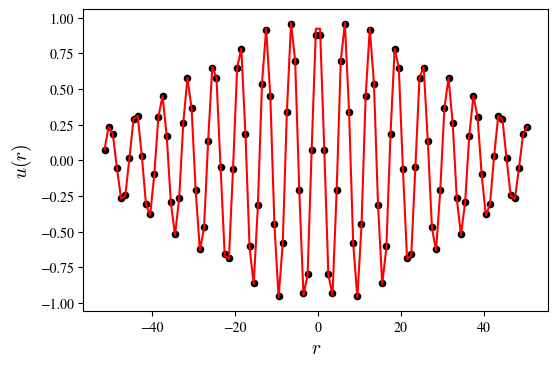

In [41]:
fig = plt.figure(dpi=100)

# Compute exact solution for dignostics purposes
u_exact = eval_u_exact(params, xx)

iplotmin = 0
iplotmax = params.N + 2*params.NGHOSTS - 1

plt.plot(xx[iplotmin:iplotmax], u[iplotmin:iplotmax], color='red')
plt.scatter(xx[iplotmin:iplotmax], u_exact[iplotmin:iplotmax], color='k', s=20.0)

plt.xlabel(r"$r$", fontsize = 14)
plt.ylabel(r"$u(r)$", fontsize = 14)


plt.show()

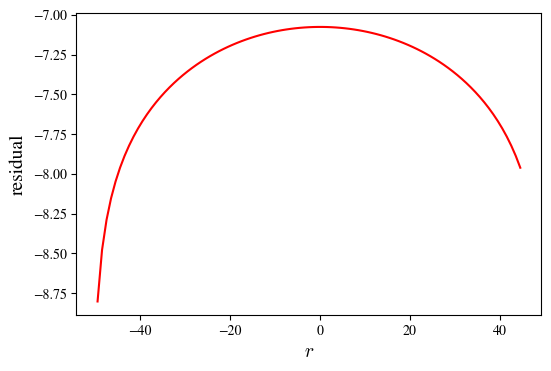

In [42]:
fig = plt.figure(dpi=100)

iplotmin = params.NGHOSTS
iplotmax = params.N - params.NGHOSTS - 1

plt.plot(xx[iplotmin:iplotmax], np.log10(np.abs(res[iplotmin:iplotmax] + 1.0e-17)), color='red')

plt.xlabel(r"$r$", fontsize = 14)
plt.ylabel("residual", fontsize = 14)


plt.show()

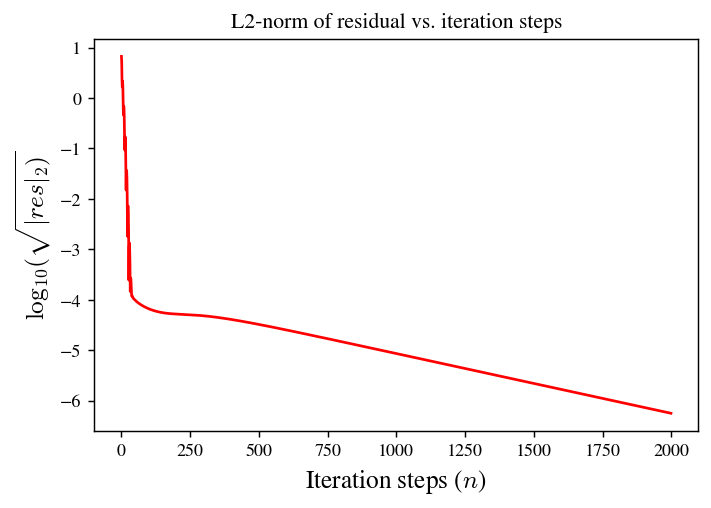

In [43]:
fig = plt.figure(dpi=130)

n_steps = np.arange(N_iter)

plt.plot(n_steps, np.log10(l2_norm_res), color='red')

plt.title("L2-norm of residual vs. iteration steps")
plt.xlabel(r"Iteration steps ($n$)", fontsize = 14)
plt.ylabel(r"$\log_{10}(\sqrt{|res|_2)}$", fontsize = 14)
plt.show()

<a id='latex_pdf_output'></a>

# Step 8: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-1D-Elliptic-solver-in-Python.pdf](Tutorial-1D-Elliptic-solver-in-Python.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [24]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-1D-Elliptic-solver-in-Python")

Created Tutorial-1D-Elliptic-solver-in-Python.tex, and compiled LaTeX file
    to PDF file Tutorial-1D-Elliptic-solver-in-Python.pdf
